Using Machine Learning to distinguish between traffic between data sent over a VPN link and traffic that isn't. 

This notebook uses datasets of preprocessed flows. Each flow is labelled with whether that flow went over a VPN or not.

## Setup - Provided by the Open University

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Provided by the Open University
BATCH_SIZE = 64

METRICS = [
      lambda : metrics.TruePositives(name='tp'),
      lambda : metrics.FalsePositives(name='fp'),
      lambda : metrics.TrueNegatives(name='tn'),
      lambda : metrics.FalseNegatives(name='fn'), 

      lambda : metrics.BinaryAccuracy(name='accuracy'),
      lambda : metrics.Precision(name='precision'),
      lambda : metrics.Recall(name='recall'),
      lambda : metrics.AUC(name='auc'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

In [ ]:
# Provided by the Open University
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, show_points=True, show_point_labels=True, **kwargs):
    """Plot the ROC curve for a binary classifer, given some labels and predictions for those labels.
    name is the name shown in the legend.
    if show_points is True, show the locations on the curve if the threshold is set to 0.25, 0.5, and 0.75."""
    
    # Calcuate the points of the curve
    fpr, tpr, ths = sklearn.metrics.roc_curve(labels, predictions)

    # Plot as percentabes
    plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate [%]')
    plt.ylabel('True positive rate [%]')
    text_x_offset = 3
    text_y_offset = 3
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
    # Show the locations of various thresholds.
    if show_points:
        for pt in [0.25, 0.5, 0.75]:  
            pi = np.argmax(ths < pt)
            px = fpr[pi] * 100
            py = tpr[pi] * 100
            plt.plot(px, py, marker="o", markersize=10, **kwargs)
            if show_point_labels:
                ax.text(x = px + text_x_offset, y = py - text_y_offset, s = f'{pt}')
    
    return fpr, tpr, ths

## Loading and preparing the dataset - Provided by the Open University

In [13]:
class_names = {0: 'Not VPN', 1: 'VPN'}

In [14]:
base_dir = '/datasets/cybersecurity/vpn-nonvpn/'

In [15]:
train_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_train'))
train_data = train_data.cache()
train_data = train_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000)
train_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
validation_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_validation'))
validation_data = validation_data.batch(BATCH_SIZE)
validation_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
test_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_test'))
test_data = test_data.batch(BATCH_SIZE)
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
input_shape = (train_data.element_spec[0].shape[1],)
input_shape

(23,)

## Jittered labels

The labels of the validation set, jittered. These have been provided by The Open University

In [19]:
validation_labels = np.array(list(validation_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_labels.shape

(1876,)

In [20]:
jittered_validation_labels = validation_labels + (np.random.random(validation_labels.shape) * 0.8)
jittered_validation_labels.shape

(1876,)

In [21]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels.shape

(3750,)

In [22]:
jittered_labels = test_labels + (np.random.random(test_labels.shape) * 0.8)
jittered_labels.shape

(3750,)

# 1st Model

Create a model with four Dense layers using RMSprop with its default learning rate. 

In [ ]:
# Create the model
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
# Set opt
opt = optimizers.RMSprop()
model2.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
# Train the model
history = model2.fit(train_data,
    validation_data=validation_data,
    epochs=300,
    verbose=0)

In [35]:
# Save the model
model2.save('q1b_sample.keras')

with open('q1b_sample_history.json', 'w') as f:
    json.dump(history.history, f)

In [36]:
# Reload the model
model2 = tf.keras.models.load_model('q1b_sample.keras')

with open('q1b_sample_history.json') as f:
    sample2_history = json.load(f)

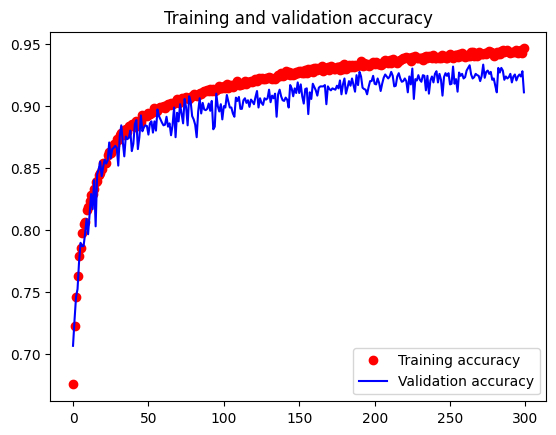

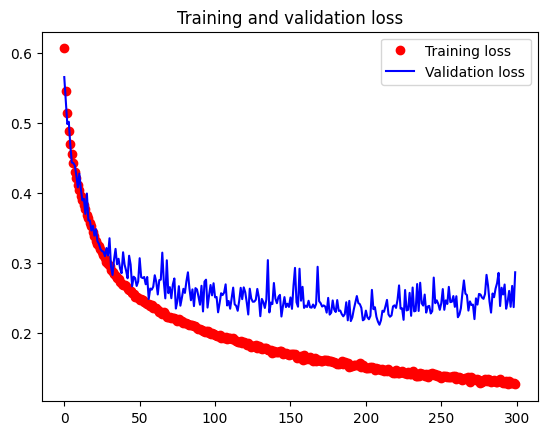

In [37]:
# Plot the training data

acc = sample2_history['accuracy']
val_acc = sample2_history['val_accuracy']
loss = sample2_history['loss']
val_loss = sample2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Comments

> Both training and validation accuracy is greater than 91% (with a difference of 2%) showing that the model has successfully modeled the training data.
> 
> The validation loss is 0.2 lower than training loss, this is to be expected. 
> The Validation loss also plateaus after 100 epochs suggesting that further training does not increase the models ability to generalize, with only small increases in validation accuracy. 
>
> Above 250 epochs, the training loss continues to decrease. However the validation loss begins to increase, something that is not reflected by a decrease in validation accuracy. This could suggest that the model is showing beginning signs of over-fitting and therefore additional training would only harm the accuracy. 



# Evaluation

Recompile the model and use he fresh_metrics function to evaluate the model against these metrics.

In [38]:
# Your solution here
# Use additional cells as needed

# Recompile the model
model2.compile(metrics=fresh_metrics(), loss='binary_crossentropy')

In [39]:
# Evaluate the training data
model2.evaluate(train_data, return_dict=True)

206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9334 - auc: 0.9861 - fn: 236.0097 - fp: 200.4010 - loss: 0.1573 - precision: 0.9385 - recall: 0.9328 - tn: 2988.5459 - tp: 3230.2319


{'accuracy': 0.9364148378372192,
 'auc': 0.9869571924209595,
 'fn': 451.0,
 'fp': 384.0,
 'loss': 0.14952227473258972,
 'precision': 0.9429505467414856,
 'recall': 0.9336569309234619,
 'tn': 5950.0,
 'tp': 6347.0}

In [40]:
# Evaluate the validation
model2.evaluate(validation_data, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9073 - auc: 0.9701 - fn: 49.9677 - fp: 42.7419 - loss: 0.2610 - precision: 0.9126 - recall: 0.9060 - tn: 447.4516 - tp: 478.9355


{'accuracy': 0.9109808206558228,
 'auc': 0.9709349870681763,
 'fn': 95.0,
 'fp': 72.0,
 'loss': 0.2860942780971527,
 'precision': 0.9241306781768799,
 'recall': 0.9022634029388428,
 'tn': 832.0,
 'tp': 877.0}

In [41]:
# Evaluate the test data
model2.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9143 - auc: 0.9703 - fn: 88.4167 - fp: 79.7000 - loss: 0.3163 - precision: 0.9173 - recall: 0.9148 - tn: 861.9500 - tp: 920.0000


{'accuracy': 0.9128000140190125,
 'auc': 0.9701710939407349,
 'fn': 176.0,
 'fp': 151.0,
 'loss': 0.29231488704681396,
 'precision': 0.9216398596763611,
 'recall': 0.9098360538482666,
 'tn': 1647.0,
 'tp': 1776.0}

In [42]:
# Generate predictions
tps = model2.predict(test_data)
model2_predictions = tps[:, 0]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluation comments:
>
> The model performs well on all three datasets, with an accuracy of 94% for training data and 91% for both validation and test data.
>
> The model good performance is also indicated by the false negative percentage being only 10% on both the validation and test data, which is only slightly up from the 7% on the training data. The false positive percentage is also incredibly low at 8% for validation and training data, compared to 6% on the training data.
>
> The precision and recall values are both high at above 0.9 for all the data.

Text(0, 0.5, 'Predictions')

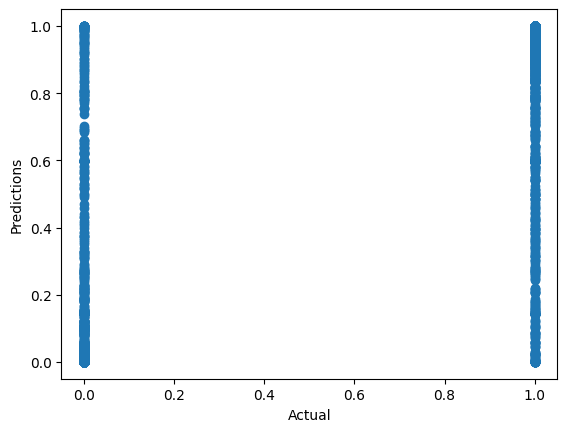

In [45]:
# Plot the test labels
plt.scatter(test_labels, model2_predictions)
plt.xlabel("Actual")
plt.ylabel("Predictions")

> All points are plotted above each other as all labels are the same.
> Jittering will solve this.

Text(0, 0.5, 'Predicitions')

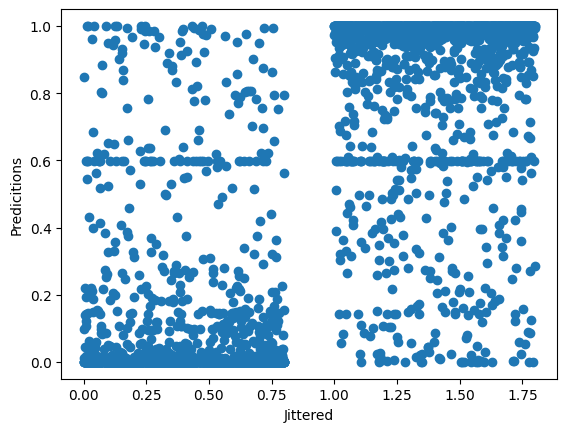

In [47]:
# Plot the jittered labels
plt.scatter(jittered_labels, model2_predictions)
plt.xlabel("Jittered")
plt.ylabel("Predicitions")

> There is some good classification here. However there are many points in the wrong half of the graph.
> There is also a large grouping of predictions around the 0.6 mark.
>
> There is a larger grouping of results in the bottom right of the graph, indicating that there are more incorrect predictions on the right hand side. 


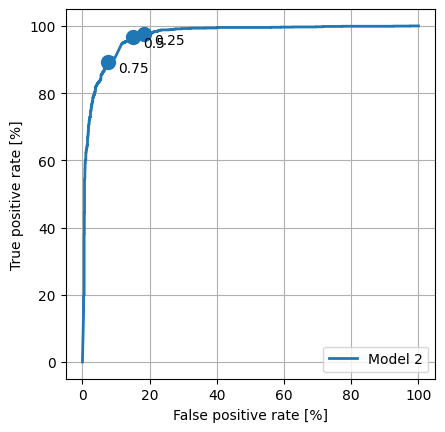

In [37]:
# Plot the ROC graph
plot_roc("Model 2", test_labels, model2_predictions, show_points=True, color=colors[0])
plt.legend(loc='lower right')

> This shows the model has a excellent accuracy level. The area under the curve of 0.97 indicates the models is incredibly good at making predictions.

# Improvements

Make improvements to the model above and evaluate on the given metrics

In [48]:
# Your solution here
# Use additional cells as needed

# 1.
# Create the model
model_e1 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
# Set opt
opt = optimizers.RMSprop()
model_e1.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
# Could calling this "history" create issues, should it
# be "history_2" for example
history = model_e1.fit(train_data,
                   validation_data = validation_data,
                   epochs=300,
                   verbose=0)

In [51]:
# Save the model
model_e1.save('q1e1_sample.keras')

with open('q1e1_sample_hisotry.json', 'w') as f:
    json.dump(history.history, f)

In [52]:
# Reload the model
model_e1 = tf.keras.models.load_model('q1e1_sample.keras')

with open('q1e1_sample_hisotry.json') as f:
    sample3_history = json.load(f)

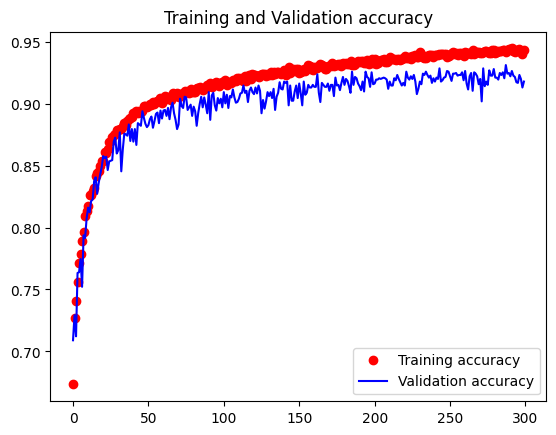

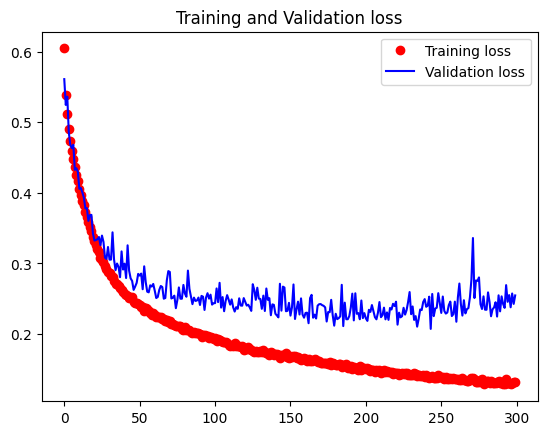

In [53]:
acc = sample3_history['accuracy']
val_acc = sample3_history['val_accuracy']
loss = sample3_history['loss']
val_loss = sample3_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Comments:
>
> This model is fairly good at making correct predictions and is excellent at decreasing its error as it learns.
>
> Its accuracy is high at above 90%.
>
> The validation begins to level out after 300 epochs and there could be a suggestion that after 250 epochs, the graph starts to show very early signs of over-fitting. 

In [66]:
# Recompile the model
model_e1.compile(metrics=fresh_metrics(), loss='binary_crossentropy')

In [67]:
# Evaluate the training data
model_e1.evaluate(train_data, return_dict=True)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - auc: 0.9905 - fn: 101.0290 - fp: 256.8164 - loss: 0.1211 - precision: 0.9308 - recall: 0.9714 - tn: 2911.7488 - tp: 3361.9807


{'accuracy': 0.9451720714569092,
 'auc': 0.9903265237808228,
 'fn': 205.0,
 'fp': 515.0,
 'loss': 0.12231404334306717,
 'precision': 0.9275464415550232,
 'recall': 0.9698440432548523,
 'tn': 5819.0,
 'tp': 6593.0}

In [68]:
# Evaluate the validation data
model_e1.evaluate(validation_data, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9123 - auc: 0.9718 - fn: 24.4839 - fp: 55.9355 - loss: 0.3088 - precision: 0.8890 - recall: 0.9453 - tn: 434.2581 - tp: 504.4193


{'accuracy': 0.9275053143501282,
 'auc': 0.9758071303367615,
 'fn': 43.0,
 'fp': 93.0,
 'loss': 0.28413236141204834,
 'precision': 0.9090019464492798,
 'recall': 0.9557613134384155,
 'tn': 811.0,
 'tp': 929.0}

In [69]:
# Evaluate the test data
model_e1.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9247 - auc: 0.9739 - fn: 49.2667 - fp: 97.8167 - loss: 0.2383 - precision: 0.9047 - recall: 0.9530 - tn: 843.8333 - tp: 959.1500


{'accuracy': 0.9242666959762573,
 'auc': 0.9748015999794006,
 'fn': 101.0,
 'fp': 183.0,
 'loss': 0.23399995267391205,
 'precision': 0.9100294709205627,
 'recall': 0.9482582211494446,
 'tn': 1615.0,
 'tp': 1851.0}

comments:
>
> This model performs well on all data. With 95% accuracy on the training data, 93% accuracy on the validation data and 92% on the test data. These are figures consistent with a good model.
>
> This is also reflected in the models false prediction percentage. The false negative percentage on the training data is 3%, is 5% on the validation data on 6% on the test data, which is incredibly low. The false positive rates are slightly worse but still good at 8% for training data and 9% for test and validation data.
>
> The models precision and recall values are both excellent at 0.91 and 0.96 on the training, validation and test data.
> 
> The high level of accuracy on the test data, confirms that no over-fitting has taken place. 

In [54]:
# Generate predictions
tps = model_e1.predict(test_data)
model_e1_predictions = tps[:,0]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Text(0, 0.5, 'Predictions')

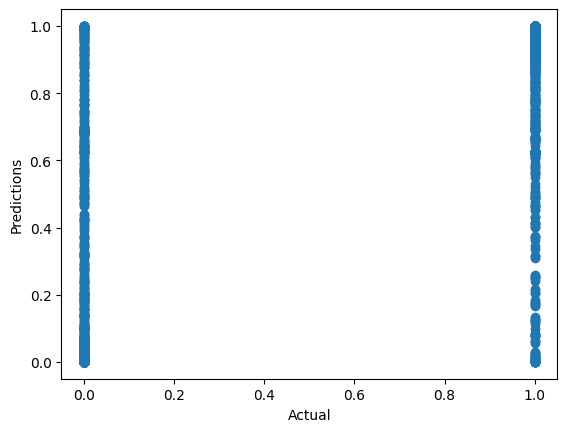

In [55]:
# Plot the test labels
plt.scatter(test_labels, model_e1_predictions)
plt.xlabel("Actual")
plt.ylabel("Predictions")

Text(0, 0.5, 'Predicitions')

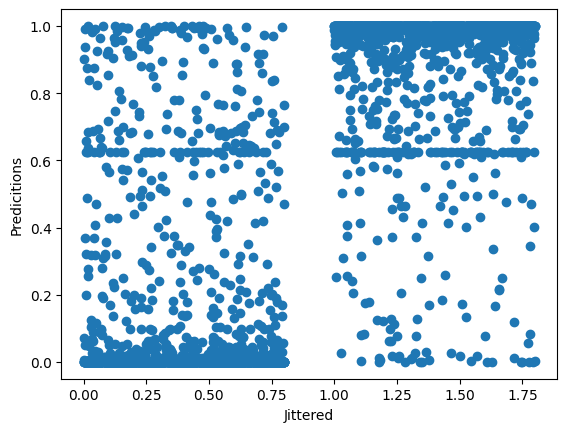

In [56]:
# Plot the jittered labels
plt.scatter(jittered_labels, model_e1_predictions)
plt.xlabel("Jittered")
plt.ylabel("Predicitions")

Comments:
>
> The grouping of some of these values are quite spaced out, this could reflect the relatively low number of epochs performed on this model in comparison to the next model we will use on this data.
> There is a good concentration of points are the 'correct' ends of the graphs which indicates predictions have a high level of accuracy.
>
> The top left of the graph appears to show a far higher density of results than the bottom right. This indicates far more false results.

In [ ]:
# Improvement 2
# Create the model number 2
model_e2 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
# Set opt
opt = optimizers.RMSprop()
model_e2.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
# Train the model
history = model_e2.fit(train_data,
    validation_data=validation_data,
    epochs=600,
    verbose=0)

In [60]:
# Save the model
model_e2.save('q1e2_sample.keras')

with open('q1e2_sample_hisotry.json', 'w') as f:
    json.dump(history.history, f)

In [61]:
# Reload the model
model_e2 = tf.keras.models.load_model('q1e2_sample.keras')

with open('q1e2_sample_hisotry.json') as f:
    sample4_history = json.load(f)

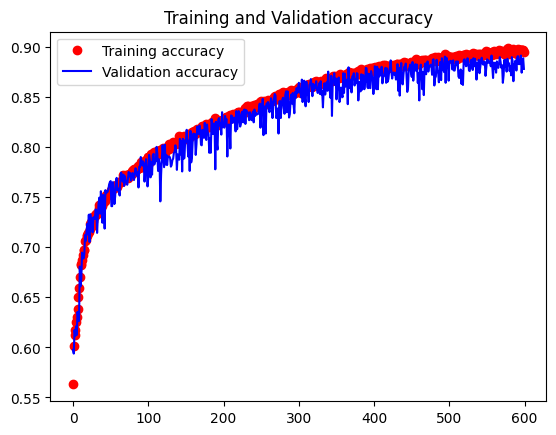

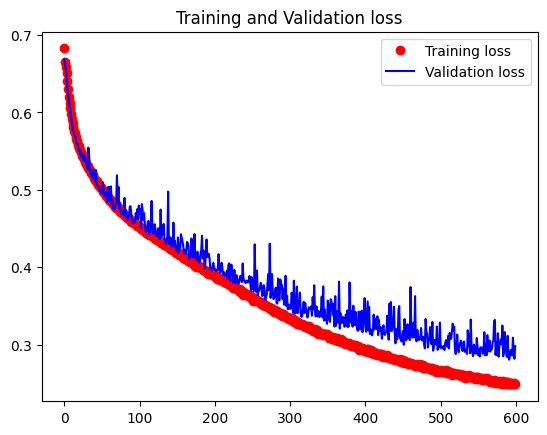

In [62]:
# Plot the training data
acc = sample4_history['accuracy']
val_acc = sample4_history['val_accuracy']
loss = sample4_history['loss']
val_loss = sample4_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Comment on the model:

> This models training and validation data follow each other closely. 
> 
> The accuracy increases throughout the training and the loss decreases throughout the training. The accuracy is fairly good as it reaches just below 90%
> 
> The model fits well, however as the graph never appears to level out, more training could still be be done to reach an even more optimal point.
> 
> There is no over or over-fitting occurring in this model.

In [63]:
# Recompile the model
model_e2.compile(metrics=fresh_metrics(), loss='binary_crossentropy')

In [64]:
# Evaluate the training data
model_e2.evaluate(train_data, return_dict=True)

206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8953 - auc: 0.9640 - fn: 387.2802 - fp: 308.2077 - loss: 0.2529 - precision: 0.9098 - recall: 0.8854 - tn: 2885.5603 - tp: 3043.4927


{'accuracy': 0.8937709331512451,
 'auc': 0.9637482762336731,
 'fn': 768.0,
 'fp': 627.0,
 'loss': 0.24999083578586578,
 'precision': 0.905813455581665,
 'recall': 0.8870255947113037,
 'tn': 5707.0,
 'tp': 6030.0}

In [65]:
# Evaluate the validation data
model_e2.evaluate(validation_data, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8579 - auc: 0.9442 - fn: 67.2258 - fp: 65.7419 - loss: 0.3055 - precision: 0.8586 - recall: 0.8628 - tn: 424.4516 - tp: 461.6774


{'accuracy': 0.8779317736625671,
 'auc': 0.953703761100769,
 'fn': 122.0,
 'fp': 107.0,
 'loss': 0.2979840338230133,
 'precision': 0.8881922960281372,
 'recall': 0.8744856119155884,
 'tn': 797.0,
 'tp': 850.0}

In [66]:
# Evaluate the test data
model_e2.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8773 - auc: 0.9532 - fn: 132.4333 - fp: 107.7167 - loss: 0.2966 - precision: 0.8870 - recall: 0.8710 - tn: 833.9333 - tp: 875.9833


{'accuracy': 0.8749333620071411,
 'auc': 0.9510056376457214,
 'fn': 261.0,
 'fp': 208.0,
 'loss': 0.3025199770927429,
 'precision': 0.8904686570167542,
 'recall': 0.8662909865379333,
 'tn': 1590.0,
 'tp': 1691.0}

> Not as accurate as the first model used in part(b), but still very accurate, with accuracy for the training data at 90%, accuracy for the validation data at 89% and 89% accuracy for the test data.
>
> The precision and recall values around 90% which is slightly worse than the previous model, which is still high.
> 
> The false prediction results for this model are very good, despite being slightly worse than the previous model. The false negative percentages for the training, validation and test data are 12%, 13% and 14% respectively and the false positive results are 9% for training data and 11% for both validation and test data. 
> 

In [67]:
# Generate predictions
tps = model_e2.predict(test_data)
model_e2_predictions = tps[:,0]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


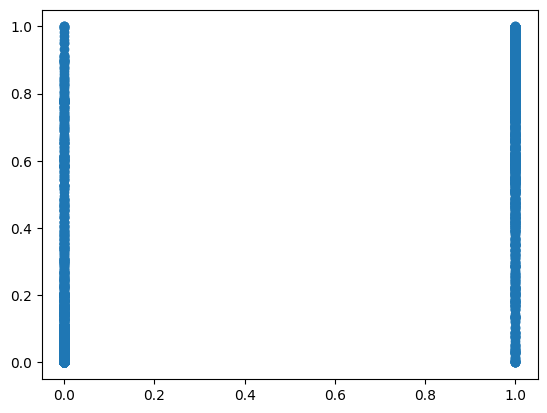

In [68]:
# Plot the test labels
plt.scatter(test_labels, model_e2_predictions)

Text(0, 0.5, 'Predicitions')

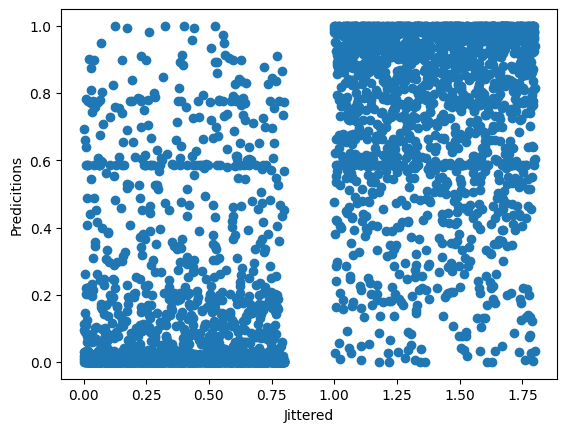

In [69]:
# Plot the jittered labels
plt.scatter(jittered_labels, model_e2_predictions)
plt.xlabel("Jittered")
plt.ylabel("Predicitions")

Comment on scatter graph:

> The grouping is far less spaced out than in the first model we used in part(b). This suggests that this model is confident of it classification.
> 
> There are some points in the wrong half of the graphs, which agrees with the models 0.88 accuracy. There is still a small grouping around the 0.6 mark, however the concentration of the points in the correct half of each side of the graph is higher than for the first model. This could be reflective of the extra 300 epochs this model was trained on.

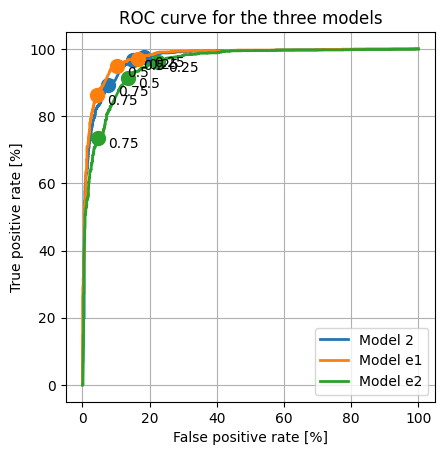

In [83]:
# Plot the ROC graph for all three models
# Plot the ROC graph
plot_roc("Model 2", test_labels, model2_predictions, color=colors[0])
plot_roc("Model e1", test_labels, model_e1_predictions, color=colors[1])
plot_roc("Model e2", test_labels, model_e2_predictions, color=colors[2])
plt.title('ROC curve for the three models')
plt.legend(loc='lower right')

Comment on ROC curves:
>
>

> The suggestion of these curves is that model e1 is the most effective, this is because it has the largest area under the curve. Model 2 would have the second largest area under the curve and model e2 would have the smallest area under the curve.
>
> This suggested that the signoid activation function did not improve the accuracy of the model. It also suggests that training the model for an additional 300 epochs didn't help either.